## <center>Inicio

In [1]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

In [2]:
import re
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

In [4]:
import xgboost as xgb

In [5]:
# Importación de los documentos
tw_train = pd.read_csv('./train.csv')
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150

In [6]:
tw_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## <center>Text: Preprocesamiento y Feature Engineering

### Location in text y Keyword in text

In [7]:
print('Se pueden distinguir {} categorías para el atributo keyword. \n(Además de los NaN)'.format(len(tw_train['keyword'].unique())-1))

Se pueden distinguir 221 categorías para el atributo keyword. 
(Además de los NaN)


In [8]:
tw_train['k_in_t'] = 0
for i in range(len(tw_train)):
    try:
        if (tw_train.loc[i, 'keyword']).lower() in (tw_train.loc[i, 'text']).lower(): tw_train.loc[i, 'k_in_t'] = 1
    except:
        continue

In [9]:
print('La cantidad de nulos en keyword es: {}'.format(tw_train['keyword'].isna().sum()))
print('La cantidad de veces que keyword no está en text es: {} (Incluye nulos)'.format((tw_train['k_in_t'] == 0).sum()))

La cantidad de nulos en keyword es: 61
La cantidad de veces que keyword no está en text es: 1640 (Incluye nulos)


In [10]:
tw_train.groupby('target')['k_in_t'].value_counts(normalize = True)

target  k_in_t
0       1         0.812529
        0         0.187471
1       1         0.747478
        0         0.252522
Name: k_in_t, dtype: float64

In [62]:
print('Se pueden distinguir {} categorías para el atributo location. \n(Además de los NaN)'.format(len(tw_train['location'].unique())-1))

Se pueden distinguir 3341 categorías para el atributo location. 
(Además de los NaN)


In [11]:
tw_train['l_in_t'] = 0
for i in range(len(tw_train)):
    try:
        if (tw_train.loc[i, 'location']).lower() in (tw_train.loc[i, 'text']).lower(): tw_train.loc[i, 'l_in_t'] = 1
    except:
        continue

In [12]:
print('La cantidad de nulos en location es: {}'.format(tw_train['location'].isna().sum()))
print('La cantidad de veces que location no está en text es: {} (Incluye nulos)'.format((tw_train['l_in_t'] == 0).sum()))

La cantidad de nulos en location es: 2533
La cantidad de veces que location no está en text es: 7534 (Incluye nulos)


In [13]:
tw_train.groupby('target')['l_in_t'].value_counts()

target  l_in_t
0       0         4316
        1           26
1       0         3218
        1           53
Name: l_in_t, dtype: int64

### Contracciones 

In [14]:
# Contracciones
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
def replace_contractions(text, mapping):
    text = ' '.join([mapping[t.lower()] if t.lower() in mapping else t for t in text.split(" ")])
    return text
tw_train['text'] = tw_train['text'].map(lambda x: replace_contractions(x, contraction_mapping))

### Largo del texto original

In [15]:
originalTextLength = tw_train['text'].map(lambda x: len(x))

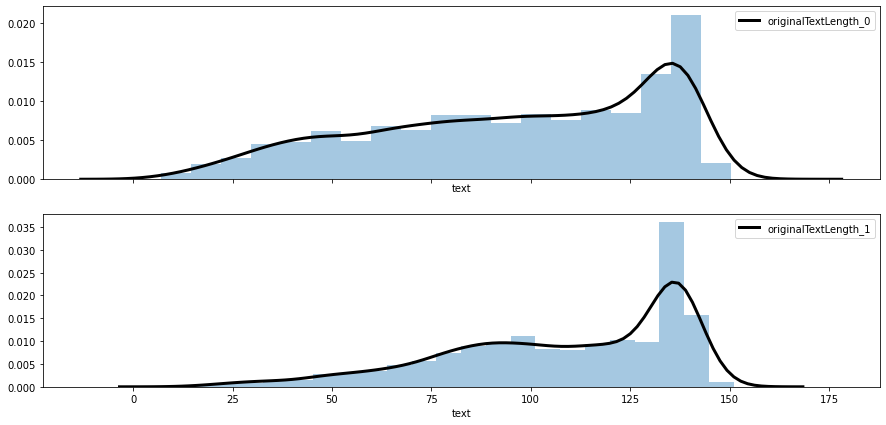

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 7), sharex = True)
originalTextLength_0 = tw_train.groupby('target').get_group(0).loc[:, 'text'].map(lambda x: len(x))
originalTextLength_1 = tw_train.groupby('target').get_group(1).loc[:, 'text'].map(lambda x: len(x))
ax1 = sns.distplot(kde = True, a = originalTextLength_0, ax = ax1, kde_kws={"color": "k", "lw": 3, "label": "originalTextLength_0"})
ax2 = sns.distplot(kde = True, a = originalTextLength_1, ax = ax2, kde_kws={"color": "k", "lw": 3, "label": "originalTextLength_1"})
plt.show()

### Características particulares de los tweets 

In [17]:
# Creación de nuevos features a partir de contabilizar ocurrencias de características especiales del texto
regexes = {'hashtags':r'(#)+', 'mentions':r'(@)\w*', 'URLs':r'(http://)[a-zA-Z0-9./]*'}
def newFeatures(regexDict, DF):
    def Qy(regex, text):   
        try:
            return len(re.compile(regex).findall(text))
        except:
            return 0
    for k, v in regexDict.items():
        DF[['text', k]] = pd.DataFrame(DF['text'].map(lambda x: [re.compile(v).sub(r' ', x), Qy(v, x)]).tolist())
        
newFeatures(regexes, tw_train)

### Largo del texto recortado

In [18]:
noTrashTextLength = tw_train['text'].map(lambda x: len(x))
tw_train['textLenght'] = noTrashTextLength

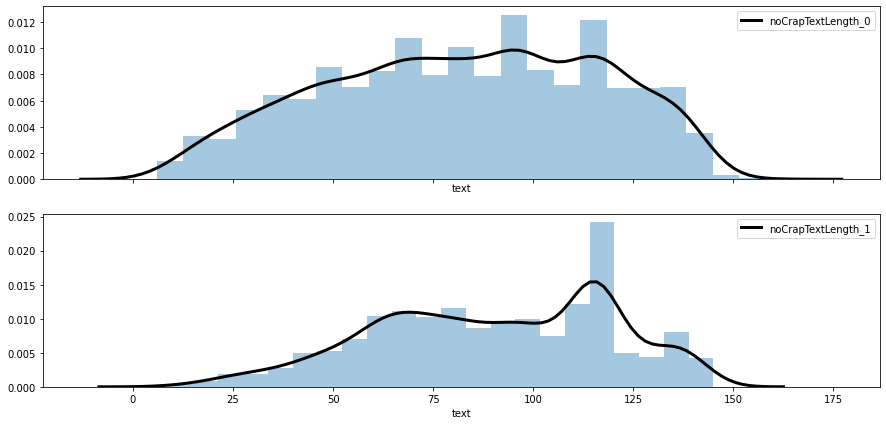

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 7), sharex = True)
noCrapTextLength_0 = tw_train.groupby('target').get_group(0).loc[:, 'text'].map(lambda x: len(x))
noCrapTextLength_1 = tw_train.groupby('target').get_group(1).loc[:, 'text'].map(lambda x: len(x))
ax1 = sns.distplot(kde = True, a = noCrapTextLength_0, ax = ax1, kde_kws={"color": "k", "lw": 3, "label": "noCrapTextLength_0"})
ax2 = sns.distplot(kde = True, a = noCrapTextLength_1, ax = ax2, kde_kws={"color": "k", "lw": 3, "label": "noCrapTextLength_1"})
plt.show()

In [20]:
textTrash = originalTextLength - noTrashTextLength
tw_train['textTrash'] = textTrash

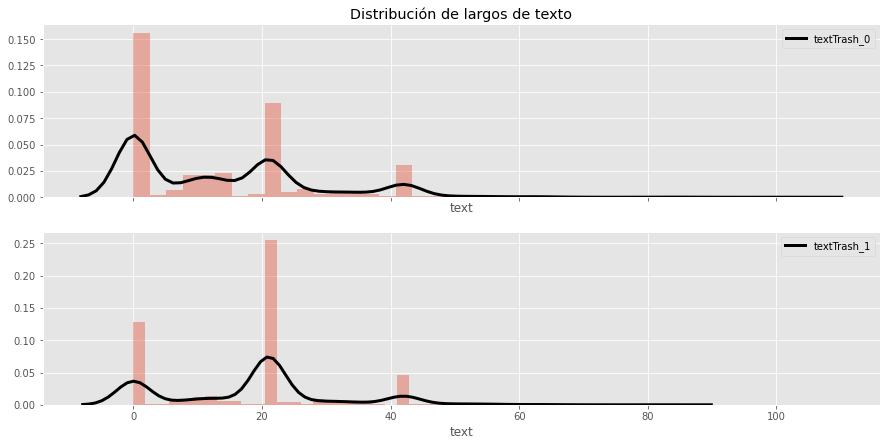

In [59]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 7), sharex = True)
textCrap_0 = originalTextLength_0 - noCrapTextLength_0
textCrap_1 = originalTextLength_1 - noCrapTextLength_1
ax1.set_title('Distribución de largos de texto')
ax1.set_xlabel('Largo')
ax1 = sns.distplot(kde = True, a = textCrap_0, ax = ax1, kde_kws={"color": "k", "lw": 3, "label": "textTrash_0"})
ax2.set_xlabel('Largo')
ax2 = sns.distplot(kde = True, a = textCrap_1, ax = ax2, kde_kws={"color": "k", "lw": 3, "label": "textTrash_1"})

plt.show()

### PoS Tagging

In [22]:
# Creación de nuevos features a partir de PoS: Presencia de cada una de las partes
def wilsonScore(num, den):
    if num == 0:
        return round(0, 2)
    phat = num/den
    z = 1.96
    return round(((phat + z*z/(2*den) - z * np.sqrt((phat*(1-phat)+z*z/(4*den))/den))/(1+z*z/den)), 2)

def posPreprocessing(text):
    tagsCount = {'ADJ':0, 'ADP':0, 'ADV':0, 'CONJ':0, 'DET':0, 'NOUN':0, 'NUM':0, 'PRT':0, 'PRON':0, 'VERB':0, '.':0, 'X':0}
    tags = []
    sentences = sent_tokenize(text)
    for sentence in sentences:
        tags += nltk.pos_tag(word_tokenize(sentence), tagset = 'universal')
    for word, tag in tags:
        tagsCount[tag] += 1    
    POS_ratio = [round((12 - list(tagsCount.values()).count(0))/12, 2)]
    mostCommonPOS_ratio = [round(list(tagsCount.values()).count(max(tagsCount.values()))/(12-list(tagsCount.values()).count(0)), 2)]    
    #noun_ratio =  [round(tagsCount['NOUN']/sum(tagsCount.values()), 2)]
    noun_ratio =  [wilsonScore(tagsCount['NOUN'], sum(tagsCount.values()))]
    return list(tagsCount.values()) + POS_ratio + mostCommonPOS_ratio + noun_ratio
        
tw_train[['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT']] = pd.DataFrame(tw_train['text'].map(lambda x: posPreprocessing(x)).tolist())

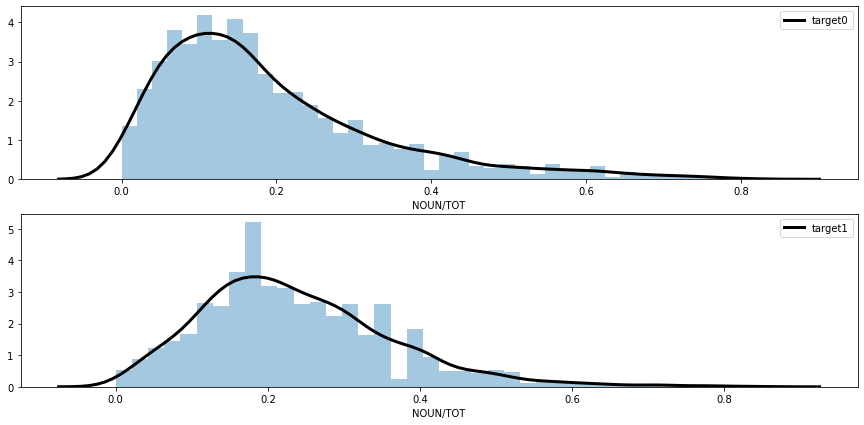

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 7))
kdedata = tw_train.groupby('target').get_group(0).loc[:, 'NOUN/TOT']
kdedata2 = tw_train.groupby('target').get_group(1).loc[:, 'NOUN/TOT']
ax1 = sns.distplot(kde = True, a = kdedata, ax = ax1, kde_kws={"color": "k", "lw": 3, "label": "target0"})
ax2 = sns.distplot(kde = True, a = kdedata2, ax = ax2, kde_kws={"color": "k", "lw": 3, "label": "target1"})
plt.show()

### Polarity y Subjectivity

In [24]:
def sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment

tw_train[['polarity', 'subjectivity']] = pd.DataFrame(tw_train['text'].map(lambda x: sentiment(x)).tolist())

### Headlines distance

In [26]:
referenceDF = pd.read_csv('./headlines_reference_values.csv').drop(columns = 'Unnamed: 0')
ref = referenceDF.loc[0]
tw_train['dist'] = 0
for i in range(len(tw_train)):
    x = tw_train.loc[i, ['textLenght','ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT', 'polarity', 'subjectivity']]
    tw_train.loc[i, 'dist'] =  np.dot(x, ref)/(np.linalg.norm(x)*np.linalg.norm(ref))

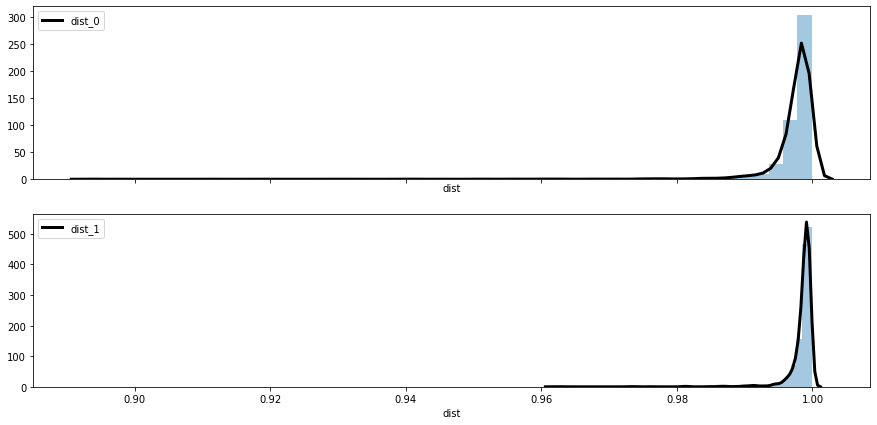

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 7), sharex = True)
dist_0 = tw_train.groupby('target').get_group(0).loc[:, 'dist']
dist_1 = tw_train.groupby('target').get_group(1).loc[:, 'dist']
ax1 = sns.distplot(kde = True, a = dist_0, ax = ax1, kde_kws={"color": "k", "lw": 3, "label": "dist_0"})
ax2 = sns.distplot(kde = True, a = dist_1, ax = ax2, kde_kws={"color": "k", "lw": 3, "label": "dist_1"})
plt.show()

### Parámetro K

In [28]:
tw_train['K'] = tw_train['textLenght']*tw_train['NOUN/TOT']*tw_train['polarity']

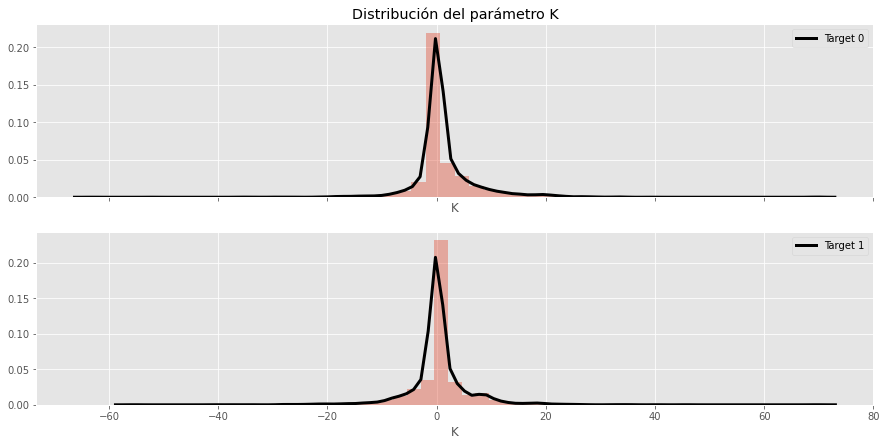

In [61]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 7), sharex = True)
K_0 = tw_train.groupby('target')['K'].get_group(0)
K_1 = tw_train.groupby('target')['K'].get_group(1)
ax1.set_title('Distribución del parámetro K')
ax1 = sns.distplot(kde = True, a = K_0, ax = ax1, bins = 50, kde_kws={"color": "k", "lw": 3, "label": "Target 0"})
ax2 = sns.distplot(kde = True, a = K_1, ax = ax2, bins = 50, kde_kws={"color": "k", "lw": 3, "label": "Target 1"})
plt.show()

### Casing

In [30]:
tw_train['text'] = tw_train['text'].map(lambda x: x.lower())

### Caracteres numéricos

In [31]:
numRegex = re.compile(r'\d')
tw_train['text'] = tw_train['text'].map(lambda x: numRegex.sub(r' ', x))

### Stopwords y Stemming

In [32]:
# Stopwords
basicStopwords = stopwords.words('english')
myStopwords = set(basicStopwords + list(punctuation))

In [33]:
# Stemming
def stemmizer(text, stopwords):
    words = word_tokenize(text)
    return ' '.join([PorterStemmer().stem(word) for word in words if word not in stopwords])

tw_train['text'] = tw_train['text'].map(lambda x: stemmizer(x, myStopwords))

### Largo del texto recortado y sin stopwords

In [34]:
noSWNoTrashTextLenght = tw_train['text'].map(lambda x: len(x))

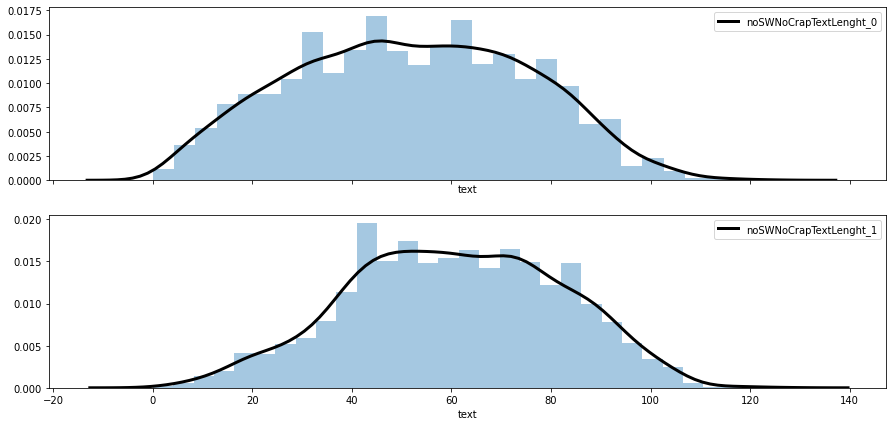

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 7), sharex = True)
noSWNoCrapTextLenght_0 = tw_train.groupby('target').get_group(0).loc[:, 'text'].map(lambda x: len(x))
noSWNoCrapTextLenght_1 = tw_train.groupby('target').get_group(1).loc[:, 'text'].map(lambda x: len(x))
ax1 = sns.distplot(kde = True, a = noSWNoCrapTextLenght_0, ax = ax1, kde_kws={"color": "k", "lw": 3, "label": "noSWNoCrapTextLenght_0"})
ax2 = sns.distplot(kde = True, a = noSWNoCrapTextLenght_1, ax = ax2, kde_kws={"color": "k", "lw": 3, "label": "noSWNoCrapTextLenght_1"})
plt.show()

In [38]:
textTrash = originalTextLength - noSWNoTrashTextLenght

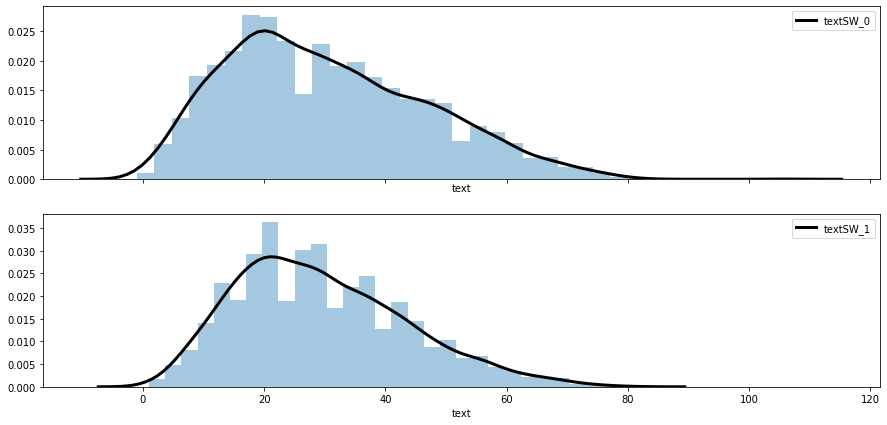

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 7), sharex = True)
textSW_0 = noCrapTextLength_0 - noSWNoCrapTextLenght_0
textSW_1 = noCrapTextLength_1 - noSWNoCrapTextLenght_1
ax1 = sns.distplot(kde = True, a = textSW_0, ax = ax1, kde_kws={"color": "k", "lw": 3, "label": "textSW_0"})
ax2 = sns.distplot(kde = True, a = textSW_1, ax = ax2, kde_kws={"color": "k", "lw": 3, "label": "textSW_1"})
plt.show()

In [63]:
tw_train.head()

,id,keyword,location,text,target,k_in_t,l_in_t,hashtags,mentions,URLs,textLenght,textTrash,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X,POS_ratio,topPOS_ratio,NOUN/TOT,polarity,subjectivity,dist,K
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1,0,0,1,0,0,69,0,0,1,0,0,3,6,0,0,2,1,0,0,0.42,0.20,0.23,0.00000,0.0000,0.998469,0.000000
1,4,NaN,NaN,forest fire near la rong sask canada,1,0,0,0,0,0,38,0,0,1,0,0,0,6,0,0,0,0,1,0,0.25,0.33,0.41,0.10000,0.4000,0.996262,1.558000
2,5,NaN,NaN,resid ask 'shelter place notifi offic evacu shelter place order expect,1,0,0,0,0,0,133,0,1,3,0,1,2,7,0,1,0,7,2,0,0.67,0.25,0.15,-0.01875,0.3875,0.998874,-0.374063
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1,0,0,1,0,0,65,0,1,1,0,0,0,5,1,0,0,0,0,0,0.33,0.25,0.31,0.00000,0.0000,0.999499,0.000000
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour school,1,0,0,2,0,0,88,0,0,4,1,0,2,6,0,0,0,3,0,0,0.42,0.20,0.18,0.00000,0.0000,0.998955,0.000000


## <center>Vocabulario

In [40]:
# Vocabulary
textList = tw_train['text'].tolist()
text = ' '.join(textList)
tokens = word_tokenize(text)

In [41]:
tokens[:5]

['deed', 'reason', 'earthquak', 'may', 'allah']

In [42]:
tokensFreq = nltk.FreqDist(tokens)
print(len(tokensFreq))
tokensFreq

12850


FreqDist({'...': 943, "'s": 414, 'http': 410, 'like': 409, 'fire': 356, 'amp': 344, 'get': 309, 'bomb': 231, 'new': 223, 'via': 218, ...})

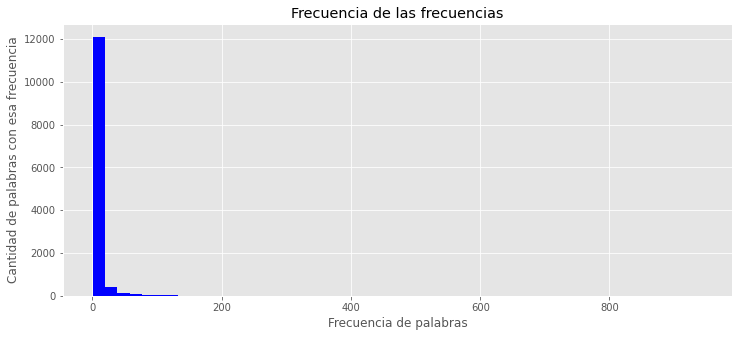

In [49]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 5))
ax.set_title('Frecuencia de las frecuencias')
ax.set_xlabel('Frecuencia de palabras')
ax.set_ylabel('Cantidad de palabras con esa frecuencia')
ax = plt.hist(tokensFreq.values(), bins = 50, color = 'blue')

plt.show()

In [50]:
tokensFreq = {k:v for k,v in tokensFreq.items() if v<150}
tokensFreq = {k:v for k,v in tokensFreq.items() if v>5}

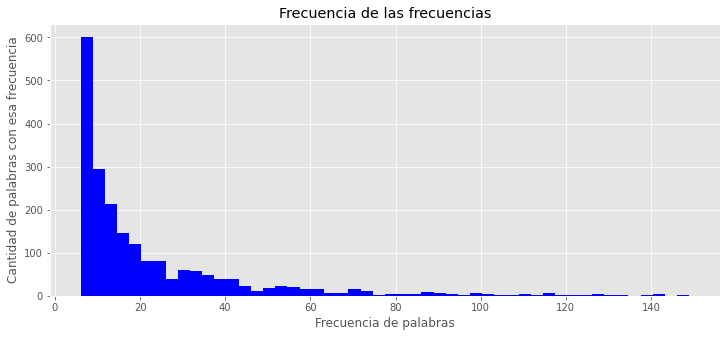

In [51]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 5))
ax.set_title('Frecuencia de las frecuencias')
ax.set_xlabel('Frecuencia de palabras')
ax.set_ylabel('Cantidad de palabras con esa frecuencia')
ax = plt.hist(tokensFreq.values(), bins = 50, color = 'blue')

plt.show()

In [52]:
len(tokensFreq)

2070

In [53]:
myVocabulary = list(tokensFreq.keys())
myVocabulary[:5]

['reason', 'earthquak', 'may', 'allah', 'us']

## Feature engineering: Encoding de keyword

In [50]:
# Entreno el encoder sin los NaN. Luego, les doy un valor arbitrario no contenido en el conjunto de categorías original de manera que, 
# en la tranformación, se les asigne el vector nulo
ohe = OneHotEncoder(handle_unknown = 'ignore')
ohe.fit(np.array(tw_train.loc[tw_train['keyword'].isna() == False, 'keyword']).reshape((-1,1)))

OneHotEncoder(handle_unknown='ignore')

In [51]:
tw_train['keyword'].fillna('NoKeyword', inplace = True)

In [52]:
tw_train_keyword_enc = ohe.transform(np.array(tw_train['keyword']).reshape((-1,1)))

In [53]:
tw_train_keyword_enc

<7613x221 sparse matrix of type '<class 'numpy.float64'>'
	with 7552 stored elements in Compressed Sparse Row format>

In [54]:
svd_kw = TruncatedSVD(n_components=100, n_iter=7, random_state=124)
tw_train_keyword_svd = svd_kw.fit_transform(tw_train_keyword_enc)

In [55]:
print('Paneo general de los AVAS:\n',svd_kw.singular_values_[:5], '...', svd_kw.singular_values_[-5:] )

Paneo general de los AVAS:
 [6.6953807  6.46630174 6.45072137 6.37514317 6.36970246] ... [5.81614194 5.80695761 5.79916626 5.79721921 5.78954286]


## Feature engineering: TF - IDF, SVD y Hashing

In [56]:
# Tokenización
count_vect = CountVectorizer(vocabulary = myVocabulary, stop_words = myStopwords) 
tw_train_text_count = count_vect.fit_transform(tw_train['text'])

In [57]:
# TF-IDF
tfidf_trans = TfidfTransformer()
tw_train_text_tfidf = tfidf_trans.fit_transform(tw_train_text_count)

In [58]:
tw_train_text_tfidf

<7613x2070 sparse matrix of type '<class 'numpy.float64'>'
	with 44844 stored elements in Compressed Sparse Row format>

In [59]:
# SVD
svd = TruncatedSVD(n_components=150, n_iter=7, random_state=123)
tw_train_text_svd = svd.fit_transform(tw_train_text_tfidf)

In [60]:
# Hashing
hash_vect = HashingVectorizer(n_features=100, stop_words = myStopwords, ngram_range = (1,1)) # Lo cambie de 150 a 100
tw_train_text_hashed = hash_vect.fit_transform(tw_train['text'])

In [61]:
tw_train_text_hashed

<7613x100 sparse matrix of type '<class 'numpy.float64'>'
	with 63072 stored elements in Compressed Sparse Row format>

## Resúmen del preprocesamiento

In [1]:
def isInText(DF, feature):
    DF[feature[0]+'_in_t'] = 0   # Inicialización de la nueva columna
    for i in range(len(DF)):
        try:
            if (tw_train.loc[i, feature]).lower() in (tw_train.loc[i, 'text']).lower(): tw_train.loc[i, feature[0]+'_in_t'] = 1
        except:
            continue
        
def replace_contractions(text, mapping):
    noContText = []
    counter = 0
    for t in text.split(" "):
        if t.lower() in mapping:
            noContText.append(mapping[t.lower()])
            counter += 1
        else:
            noContText.append(t) 
    return [' '.join(noContText), counter]

def Qy(regex, text):   
    try:
        return len(re.compile(regex).findall(text))
    except:
        return 0

def newFeatures(DF, regexDict):
    for k, v in regexDict.items():
        DF[['text', k]] = pd.DataFrame(DF['text'].map(lambda x: [re.compile(v).sub(r' ', x), Qy(v, x)]).tolist())

def wilsonScore(num, den):
    if num == 0:
        return round(0, 2)
    phat = num/den
    z = 1.96
    return round(((phat + z*z/(2*den) - z * np.sqrt((phat*(1-phat)+z*z/(4*den))/den))/(1+z*z/den)), 2)

def tagging(text):
    tagsCount = {'ADJ':0, 'ADP':0, 'ADV':0, 'CONJ':0, 'DET':0, 'NOUN':0, 'NUM':0, 'PRT':0, 'PRON':0, 'VERB':0, '.':0, 'X':0}
    tags = []
    sentences = sent_tokenize(text)
    for sentence in sentences:
        tags += nltk.pos_tag(word_tokenize(sentence), tagset = 'universal')
    for word, tag in tags:
        tagsCount[tag] += 1    
    POS_ratio = [round((12 - list(tagsCount.values()).count(0))/12, 2)]
    mostCommonPOS_ratio = [round(list(tagsCount.values()).count(max(tagsCount.values()))/(12-list(tagsCount.values()).count(0)), 2)]    
    noun_ratio =  [wilsonScore(tagsCount['NOUN'], sum(tagsCount.values()))]
    return list(tagsCount.values()) + POS_ratio + mostCommonPOS_ratio + noun_ratio

def headlinesDistance(DF, ref):
    DF['dist'] = 0
    for i in range(len(DF)):
        x = DF.loc[i, ['textLenght','ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT']]
        DF.loc[i, 'dist'] =  np.dot(x, ref)/(np.linalg.norm(x)*np.linalg.norm(ref))

def sentimentAnalysis(text):
    blob = TextBlob(text)
    return blob.sentiment

def stemmizer(text, stopwords):
    words = word_tokenize(text)
    return ' '.join([PorterStemmer().stem(word) for word in words if word not in stopwords])
    
def preprocessing(DF, contraction_mapping, regexes, ref, myStopwords):
#     originalTextLength = tw_train['text'].map(lambda x: len(x))
    isInText(DF, 'keyword')
    isInText(DF, 'location')
    DF[['text', 'conts']] = pd.DataFrame(DF['text'].map(lambda x: replace_contractions(x, contraction_mapping)).tolist())
    originalTextLength = DF['text'].map(lambda x: len(x))
    newFeatures(DF, regexes) 
    DF['textLenght'] = DF['text'].map(lambda x: len(x))
    DF['textCrap'] = originalTextLength - DF['textLenght']
    DF[['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT']] = pd.DataFrame(DF['text'].map(lambda x: tagging(x)).tolist())
    headlinesDistance(DF, ref)
    DF[['polarity', 'subjectivity']] = pd.DataFrame(DF['text'].map(lambda x: sentimentAnalysis(x)).tolist())
    DF['K'] = DF['textLenght']*DF['NOUN/TOT']*DF['polarity']
    DF['text'] = DF['text'].map(lambda x: x.lower())
    DF['text'] = DF['text'].map(lambda x: re.compile(r'\d').sub(r' ', x))
    DF['text'] = DF['text'].map(lambda x: stemmizer(x, myStopwords))

In [162]:
tw_train2 = pd.read_csv('./train.csv')

In [163]:
preprocessing(tw_train2, contraction_mapping, regexes, ref, myStopwords)

In [164]:
tw_train2.head(10)

,id,keyword,location,text,target,k_in_t,l_in_t,conts,hashtags,mentions,URLs,textLenght,textCrap,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X,POS_ratio,topPOS_ratio,NOUN/TOT,dist,polarity,subjectivity,K
0,1,NaN,NaN,u r e e r e h e r e n f h e r h q u k e l l h f r g v e u l l,1,0,0,0,1,0,0,137,0,5,1,0,0,6,36,0,0,0,8,0,0,0.42,0.20,0.51,0.983353,0.0,0.0,0.0
1,4,NaN,NaN,f r e f r e n e r l r n g e k c n,1,0,0,0,0,0,0,75,0,3,0,0,0,6,17,0,0,0,4,1,1,0.50,0.17,0.36,0.986488,0.0,0.0,0.0
2,5,NaN,NaN,l l r e e n k e h e l e r n p l c e r e b e n g n f e b f f c e r n h e r e v c u n r h e l e r n p l c e r e r r e e x p e c e,1,0,0,0,0,0,0,265,0,6,5,0,0,8,76,0,0,0,14,3,0,0.50,0.17,0.59,0.979909,0.0,0.0,0.0
3,6,NaN,NaN,p e p l e r e c e v e w l f r e e v c u n r e r n c l f r n,1,0,0,0,1,0,0,129,0,2,3,0,0,4,33,5,0,0,8,1,0,0.58,0.14,0.46,0.984280,0.0,0.0,0.0
4,7,NaN,NaN,j u g e n h p h f r r u b l k k e f r w l f r e p u r n c h l,1,0,0,0,2,0,0,175,0,9,1,0,0,4,50,0,0,0,6,0,0,0.42,0.20,0.60,0.980091,0.0,0.0,0.0
5,8,NaN,NaN,r c k f r e u p e c l f r n h w c l e n b h r e c n u e l k e c u n f r e c f r e w l f r e,1,0,0,0,3,0,0,219,0,8,0,0,0,5,57,2,0,0,15,2,1,0.58,0.14,0.53,0.983856,0.0,0.0,0.0
6,10,NaN,NaN,f l e r h e v r n c u e f l h f l n g f r e e n n u c l r p r n g r e,1,0,0,0,2,0,0,189,0,5,2,0,0,9,51,0,0,0,12,1,0,0.50,0.17,0.53,0.982001,0.0,0.0,0.0
7,13,NaN,NaN,n p f h e h l l n c n e e f r e n h e w,1,0,0,1,0,0,0,117,0,5,1,0,0,3,24,0,0,2,6,4,0,0.58,0.14,0.39,0.991266,0.0,0.0,0.0
8,14,NaN,NaN,h e r e n e e r g e n c e v c u n h p p e n n g n w n h e b u l n g c r h e r e e,1,0,0,1,0,0,0,157,0,7,6,1,0,5,41,0,0,0,7,1,0,0.58,0.14,0.48,0.983948,0.0,0.0,0.0
9,15,NaN,NaN,f r h h e r n c n g u r r e,1,0,0,1,0,0,0,103,0,2,2,0,0,6,24,0,0,1,4,4,0,0.58,0.14,0.41,0.986975,0.0,0.0,0.0


In [167]:
tw_train2.groupby('target')['conts'].value_counts(normalize = True)

target  conts
0       0        0.811838
        1        0.152464
        2        0.030631
        3        0.005067
1       0        0.917151
        1        0.067869
        2        0.013146
        3        0.001834
Name: conts, dtype: float64

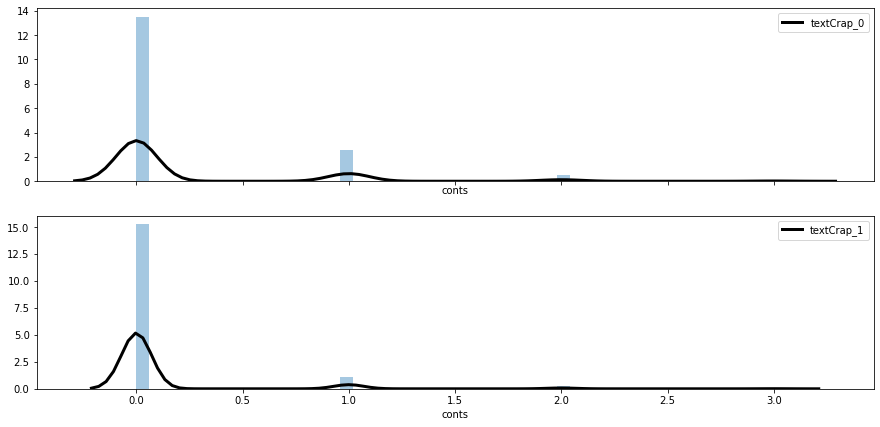

In [165]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 7), sharex = True)
textCrap_0 = tw_train2.groupby('target').get_group(0)['conts']
textCrap_1 = tw_train2.groupby('target').get_group(1)['conts']
ax1 = sns.distplot(kde = True, a = textCrap_0, ax = ax1, kde_kws={"color": "k", "lw": 3, "label": "textCrap_0"})
ax2 = sns.distplot(kde = True, a = textCrap_1, ax = ax2, kde_kws={"color": "k", "lw": 3, "label": "textCrap_1"})
plt.show()

## Reducción de dimensiones

In [169]:
tw_train2.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'k_in_t', 'l_in_t',
       'conts', 'hashtags', 'mentions', 'URLs', 'textLenght', 'textCrap',
       'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRT', 'PRON',
       'VERB', '.', 'X', 'POS_ratio', 'topPOS_ratio', 'NOUN/TOT', 'dist',
       'polarity', 'subjectivity', 'K'],
      dtype='object')

In [170]:
tw_train_subset = tw_train2[['k_in_t', 'l_in_t',
       'conts', 'hashtags', 'mentions', 'URLs', 'textLenght', 'textCrap',
       'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRT', 'PRON',
       'VERB', '.', 'X', 'POS_ratio', 'topPOS_ratio', 'NOUN/TOT', 'dist',
       'polarity', 'subjectivity', 'K']]
X = sparse.hstack((tw_train_text_tfidf, sparse.csr_matrix(tw_train_subset.values)))
X = sparse.hstack((tw_train_keyword_enc, X))
y = tw_train['target']

In [171]:
SVD = TruncatedSVD(n_components=2, n_iter=7, random_state=678)
X_svd = SVD.fit_transform(X)

In [172]:
scatter_data = np.concatenate((X_svd, np.array(tw_train['target']).reshape(-1,1)), axis = 1)

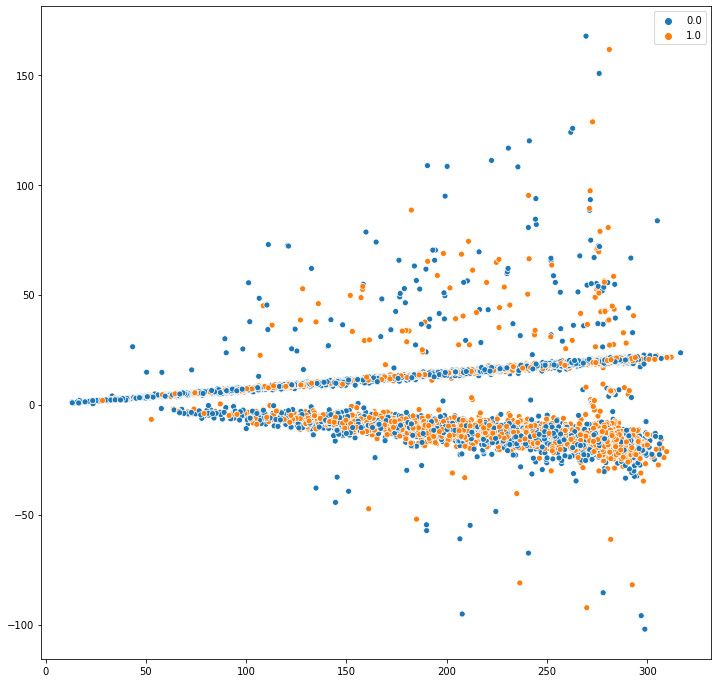

In [173]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,12))
sns.scatterplot(ax = ax, x = scatter_data[:, 0], y = scatter_data[:, 1], hue = scatter_data[:, 2])

In [174]:
from sklearn.decomposition import KernelPCA

In [207]:
kpca = KernelPCA(n_components = 2, kernel = 'sigmoid', random_state = 456)

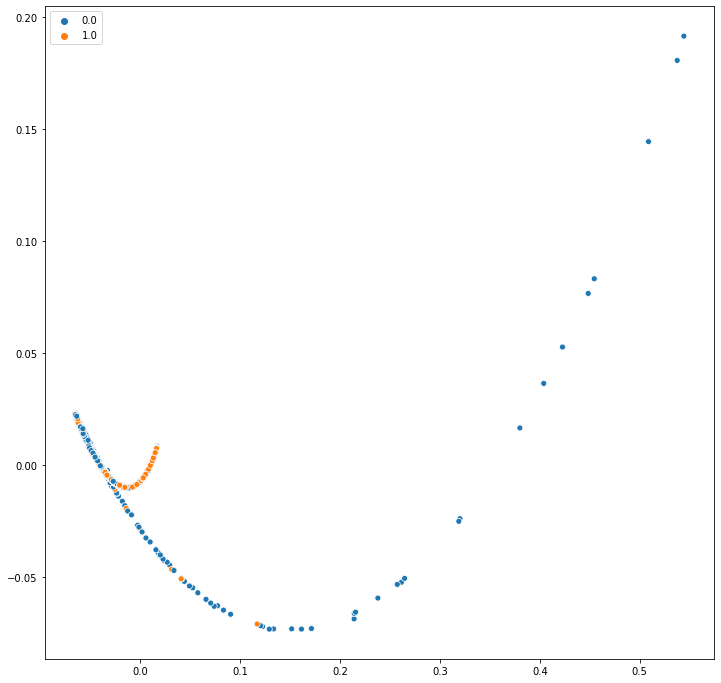

In [208]:
X_kpca = kpca.fit_transform(X)
scatter_data = np.concatenate((X_kpca, np.array(tw_train['target']).reshape(-1,1)), axis = 1)
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,12))
sns.scatterplot(ax = ax, x = scatter_data[:, 0], y = scatter_data[:, 1], hue = scatter_data[:, 2])

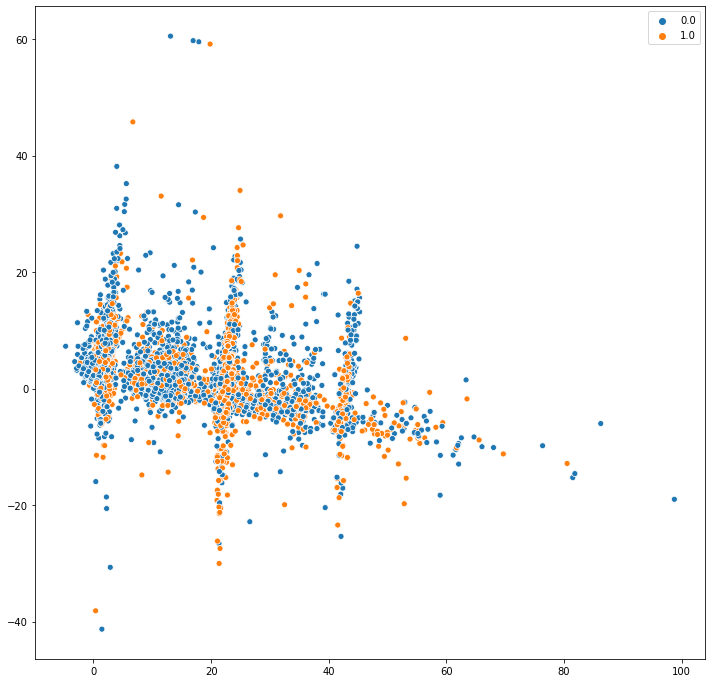

In [77]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,12))
sns.scatterplot(ax = ax, x = scatter_data[:, 0], y = scatter_data[:, 1], hue = scatter_data[:, 2])

## XGBoost reduciendo el set completo

In [194]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.20, random_state=23)
X_train, X_test, y_train, y_test = train_test_split(X_kpca, y, stratify = y, test_size=0.20, random_state=23)

In [79]:
# xgb_pipe = Pipeline([('svd', TruncatedSVD()), ('xgb_clf', xgb.XGBClassifier())])

In [80]:
# paramsDict = {'svd__n_components':[150, 200, 250], 'xgb_clf__n_estimators':[100, 200, 300]}


In [200]:
# xgb_pipe_gs = GridSearchCV(estimator = xgb_pipe, param_grid = paramsDict, cv = 5, n_jobs = -1)
xgb_pipe_gs = xgb.XGBClassifier(n_estimators = 500)

In [201]:
xgb_pipe_gs.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
xgb_pipe_gs.best_params_

{'svd__n_components': 250, 'xgb_clf__n_estimators': 200}

In [87]:
xgb_pipe_gs.best_score_

0.7676518883415435

In [202]:
predicted = xgb_pipe_gs.predict(X_test)

In [203]:
# Más evaluación
print('ERROR DE VALIDACIÓN:\n')
print('El F1-Score es: {} \n'.format(f1_score(y_test, predicted)))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(y_test, predicted)))
print('El classification report es: \n{} \n'.format(classification_report(y_test, predicted)))

ERROR DE VALIDACIÓN:

El F1-Score es: 0.4690763052208835 

La confusion matrix es: 
[[570 299]
 [362 292]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.61      0.66      0.63       869
           1       0.49      0.45      0.47       654

    accuracy                           0.57      1523
   macro avg       0.55      0.55      0.55      1523
weighted avg       0.56      0.57      0.56      1523
 



In [204]:
# Más evaluación
print('ERROR DE ENTRENAMIENTO:\n')
print('El F1-Score es: {} \n'.format(f1_score(y_train, xgb_pipe_gs.predict(X_train))))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(y_train, xgb_pipe_gs.predict(X_train))))
print('El classification report es: \n{} \n'.format(classification_report(y_train, xgb_pipe_gs.predict(X_train))))

ERROR DE ENTRENAMIENTO:

El F1-Score es: 0.8486529318541998 

La confusion matrix es: 
[[3184  289]
 [ 475 2142]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      3473
           1       0.88      0.82      0.85      2617

    accuracy                           0.87      6090
   macro avg       0.88      0.87      0.87      6090
weighted avg       0.87      0.87      0.87      6090
 

